# Analiza zbioru danych związanych z katastrofą Titanica
### Na podsawie poniższej analizy chciałbym zobaczyć, określić i wskazać które z czynników kluczowe są w kontekście przeżywaloności pasażerów statku. Wykorzystać model predykcyjny, aby wskazać który z pasażerów w zbiorze testowym mógł przeżyć.

## 1. Określenie Problemu
### Zrozumienie wpływu czynników decydujących na przezprzywalności pasażerów podczas katastrofy Titanica.
* Czy istnieje różnica w szansach przeżycia między mężczyznami a kobietami?
* Czy klasa biletu związna była z większą szansą przeżycia?
* Czy wiek pasażera miał wpływ na jego szanse przeżycia?
* Czy inne czynniki, takie jak stan cywilny, wielkość rodziny, bądz miejsce na statku miały istone znaczenie.

## 2. Wstępne zapoznanie się z danymi 
### Załadowanie podstawowych bibliotek, oraz bazy danych.

In [1]:
#Obliczenia  i analiza  danych
import numpy as np
import pandas as pd

#wizualiacja 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('icefire_r', 2)


%matplotlib inline
#Przetwarzanie

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
# Baza danych gównych do nauki modelu
Titanic = pd.read_csv("Titanic_Database.csv") 
# Baza danych Titanica do sprawdzenia modelu
test = pd.read_csv("test.csv")

In [2]:
Titanic.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [3]:
print(Titanic.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Zbiór danych zawiera następujące informacje:

*  PassengerId: Unikatowy identyfikator pasażera
*  Survived: Czy pasażer przeżył (1) czy zginął (0)
*  Pclass: Klasa biletu (1=pierwsza, 2=druga, 3=trzecia)
*  Name: Imię i nazwisko pasażera, staus cywilny
*  Sex: Płeć pasażera (male, female)
*  Age: Wiek pasażera
*  SibSp: Liczba rodzeństwa i/lub małżonka na pokładzie
*  Parch: Liczba rodziców i/lub dzieci na pokładzie
*  Ticket: Numer biletu
*  Fare: Cena biletu
*  Cabin: Numer kabiny
*  Embarked: Port zaokrętowania (C = Cherbourg, Q = Queenstown, S = Southampton)

## 3. Czyszczenie i przygotowanie danych

In [4]:
#Sprawdzenie wartości zerowych dla głównej bazy danych
print(pd.isnull(Titanic).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [5]:
print(pd.isnull(test).sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


#### W przypadku głownej bazy danych brakuje 177 kluczowych wartość dla parametru Age, natomiast w przypadku bazy testowej jest to 86 brakująchyc wartości. Kategoria Cabin zostanie w początkowej fazie testó usunięta.


In [6]:
# Dodanie kategori Roodzina jako suma paramtrów SibSp, oraz Parch
for df in [Titanic, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch']

### Encodowanie danych kategorycznych

#### Płeć.

In [7]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

for df in [Titanic, test]:
    sex_encoded = encoder.fit_transform(df['Sex'].values.reshape(-1, 1))  # Dopasuj i przekształc jednocześnie
    df['Sex_Enc'] = sex_encoded

### Male = 1 ||| Female = 0 

#### Stan cywilny paseżerów.

In [8]:
def get_title(name):
    # Wyodrębnij prefix z imienia
    title = name.split(',')[1].split('.')[0].strip()
    if title in ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return 'Rare'
    elif title in ['Mlle']:
        return 'Miss'
    elif title in ['Ms']:
        return 'Miss'
    elif title in ['Mme']:
        return 'Mrs'
    else:
        return title

Titanic['Title'] = Titanic['Name'].apply(get_title)
test['Title']    = test['Name'].apply(get_title)
##
#title_percentages1 = Titanic['Title'].value_counts(normalize=True)
#title_percentages2 = test['Title'].value_counts(normalize=True)
#print(title_percentages1)
#print(title_percentages2)

In [9]:
title_mapping = {
    "Mr": 0,
    "Miss": 1,
    "Mrs": 2,
    "Master": 3,
    "Rare": 4,
    "the Countess": 5
}

for df in [Titanic, test]:
    df['Title_Enc'] = np.array([title_mapping[x] for x in df['Title']])

# title_percentages1 = Titanic['Title_Enc'].value_counts(normalize=True)
# title_percentages2 = test['Title_Enc'].value_counts(normalize=True)
# print(title_percentages1)
# print(title_percentages2)

#### Port zaokrętowania

In [10]:
title_mapping = {
    "C": 0,
    "Q": 1,
    "S": 2,
}

for df in [Titanic, test]:
    df['Embarked'] =     pd.Categorical(df['Embarked'])
    df['Embarked_Enc'] = df['Embarked'].cat.codes

# title_percentages1 = Titanic['Embarked_Enc'].value_counts(normalize=True)
# title_percentages2 = test['Embarked_Enc'].value_counts(normalize=True)
# print(title_percentages1)
# print(title_percentages2)

#### Uzupełnianie brakujących wartości
Znacząco wybiegając w przyszłość, ponieważ kolumny Age, Embarked i Fare posiadają brakujące wartości, więc wykorzystam imputer KNN, aby uzupełnić brakujące wartości

In [11]:
# Utwórz imputer KNN
imputer = KNNImputer(n_neighbors=5)
# Dopasuj imputer do danych
for df in [Titanic, test]:
    imputer.fit(df[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']].dropna())
    df['Age'] = imputer.transform(df[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']])

In [12]:
### Dziwny błąd 
mask = Titanic['Embarked_Enc'] == -1
Titanic.loc[mask, 'Embarked_Enc'] = np.nan


# Utwórz imputer KNN
imputer = KNNImputer(n_neighbors=5)
# Dopasuj imputer do danych
for df in [Titanic, test]:
    imputer.fit(df[['Embarked_Enc' ,'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']].dropna())
    df['Embarked_Enc'] = imputer.transform(df[['Embarked_Enc', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']])

In [13]:
# Utwórz imputer KNN
imputer = KNNImputer(n_neighbors=5)
# Dopasuj imputer do danych
imputer.fit(test[['Fare', 'Age', 'Pclass', 'SibSp', 'Parch' ]].dropna())
df['Fare'] = imputer.transform(test[['Fare', 'Age', 'Pclass', 'SibSp', 'Parch' ]])

In [14]:
print(pd.isnull(Titanic).sum())

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
FamilySize        0
Sex_Enc           0
Title             0
Title_Enc         0
Embarked_Enc      0
dtype: int64


In [15]:
print(pd.isnull(test).sum())

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           327
Embarked          0
FamilySize        0
Sex_Enc           0
Title             0
Title_Enc         0
Embarked_Enc      0
dtype: int64


## Wybór danych
#### Ocena kategorii, które mogą zostać bezwzględnie usunięte ponieważ nie planuję uwzględniać ich dalszej części modelowania, bądz zostały zencodowane.   

In [16]:
# Usuń oryginalne kolumny
categorical_features = ['PassengerId','Name', 'Title', 'Sex', 'Ticket','Cabin', 'Embarked']
Titanic.drop(columns=categorical_features, inplace=True)
Titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,30.075239,0.523008,0.381594,32.204208,0.904602,0.647587,0.729517,1.533333
std,0.486592,0.836071,13.535628,1.102743,0.806057,49.693429,1.613459,0.477990,1.034144,0.792493
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,2.000000
75%,1.000000,3.000000,38.500000,1.000000,0.000000,31.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000,1.000000,5.000000,2.000000


In [17]:
categorical_features = ['PassengerId','Name', 'Title', 'Sex', 'Ticket','Cabin', 'Embarked']
test.drop(columns=categorical_features, inplace=True)
test.describe()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,29.735167,0.447368,0.392344,35.613884,0.839713,0.636364,0.741627,1.401914
std,0.841838,12.932250,0.896760,0.981429,55.841163,1.519072,0.481622,1.006091,0.854496
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,1.000000
50%,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,2.000000
75%,3.000000,36.075000,1.000000,0.000000,31.471875,1.000000,1.000000,1.000000,2.000000
max,3.000000,76.000000,8.000000,9.000000,512.329200,10.000000,1.000000,4.000000,2.000000


In [18]:
Titanic[['Age', 'Fare']] = Titanic[['Age', 'Fare']].astype(np.float32)
columns_to_convert = ['Survived' ,'Pclass', 'SibSp', 'FamilySize',  'Parch', 'Sex_Enc', 'Embarked_Enc', 'Title_Enc']
Titanic[columns_to_convert] = Titanic[columns_to_convert].astype(np.int16)
Titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int16  
 1   Pclass        891 non-null    int16  
 2   Age           891 non-null    float32
 3   SibSp         891 non-null    int16  
 4   Parch         891 non-null    int16  
 5   Fare          891 non-null    float32
 6   FamilySize    891 non-null    int16  
 7   Sex_Enc       891 non-null    int16  
 8   Title_Enc     891 non-null    int16  
 9   Embarked_Enc  891 non-null    int16  
dtypes: float32(2), int16(8)
memory usage: 21.0 KB


In [19]:
test[['Age', 'Fare']] = test[['Age', 'Fare']].astype(np.float32)
columns_to_convert = ['Pclass', 'SibSp', 'Parch', 'FamilySize', 'Sex_Enc', 'Embarked_Enc', 'Title_Enc']
test[columns_to_convert] = test[columns_to_convert].astype(np.int16)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        418 non-null    int16  
 1   Age           418 non-null    float32
 2   SibSp         418 non-null    int16  
 3   Parch         418 non-null    int16  
 4   Fare          418 non-null    float32
 5   FamilySize    418 non-null    int16  
 6   Sex_Enc       418 non-null    int16  
 7   Title_Enc     418 non-null    int16  
 8   Embarked_Enc  418 non-null    int16  
dtypes: float32(2), int16(7)
memory usage: 9.1 KB


## 4. Wizualizacja i ekspoloracja wzorców

In [20]:
Titanic.groupby('Sex_Enc').mean().round(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Title_Enc,Embarked_Enc
Sex_Enc,,,,,,,,,
0,0.74,2.16,28.490000,0.69,0.65,44.48,1.34,1.43,1.41
1,0.19,2.39,30.940001,0.43,0.24,25.52,0.67,0.35,1.60


In [21]:
test.groupby('Sex_Enc').mean().round(2)

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Title_Enc,Embarked_Enc
Sex_Enc,,,,,,,,
0,2.14,29.84,0.57,0.60,49.750000,1.16,1.49,1.32
1,2.33,29.67,0.38,0.27,27.540001,0.65,0.31,1.45


In [22]:
Titanic.groupby('Pclass').mean().round(2)

,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
Pclass,,,,,,,,,
1,0.63,38.490002,0.42,0.36,84.150002,0.77,0.56,0.94,1.19
2,0.47,30.330000,0.40,0.38,20.660000,0.78,0.59,0.96,1.80
3,0.24,26.280001,0.62,0.39,13.680000,1.01,0.71,0.55,1.58


In [23]:
test.groupby('Pclass').mean().round(2)

,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
Pclass,,,,,,,,
1,40.599998,0.48,0.38,94.279999,0.86,0.53,0.99,0.94
2,28.879999,0.38,0.34,22.200001,0.72,0.68,0.62,1.72
3,24.770000,0.46,0.42,12.540000,0.88,0.67,0.67,1.49


In [24]:
Titanic.groupby('Survived').mean().round(2)

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_Enc,Title_Enc,Embarked_Enc
Survived,,,,,,,,,
0,2.53,30.639999,0.55,0.33,22.120001,0.88,0.85,0.40,1.64
1,1.95,29.160000,0.47,0.46,48.400002,0.94,0.32,1.26,1.36


W przypadku bazy danych test. oczywiście kolumna z przeżywalnością nie występuje. To ją chce określić dla owej testowej bazy danych.

Text(0.5, 1.05, 'Macierz korelacji Perasona')

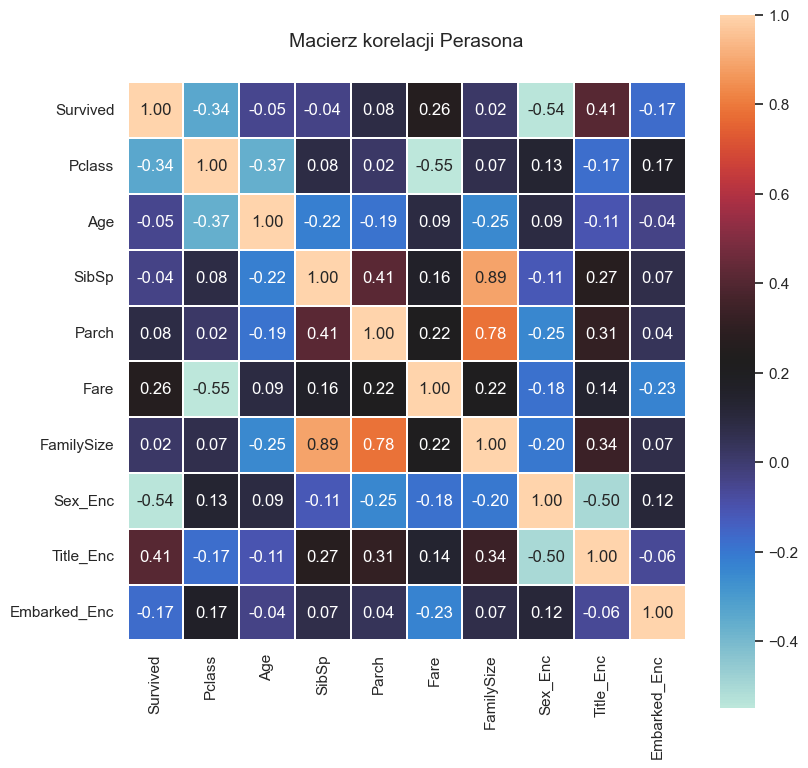

In [25]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(Titanic.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
ax.set_title('Macierz korelacji Perasona', y=1.05,   size=14)

Text(0.5, 1.05, 'Macierz korelacji Perasona')

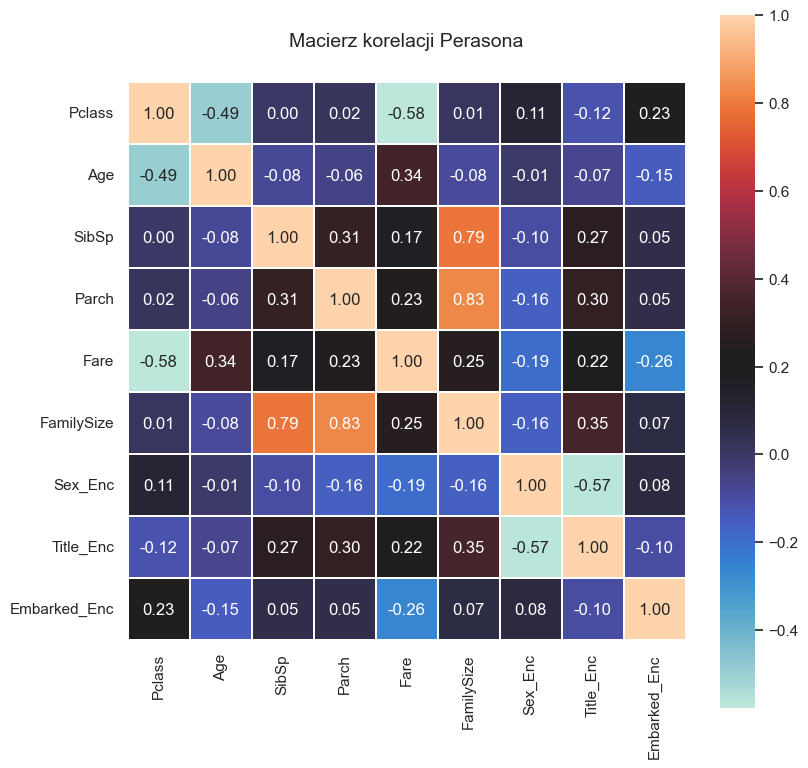

In [26]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(test.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
ax.set_title('Macierz korelacji Perasona', y=1.05, size=14)

In [27]:
#sns.pairplot(Titanic, hue="Survived", kind="kde", corner=True)

###  Age distribution

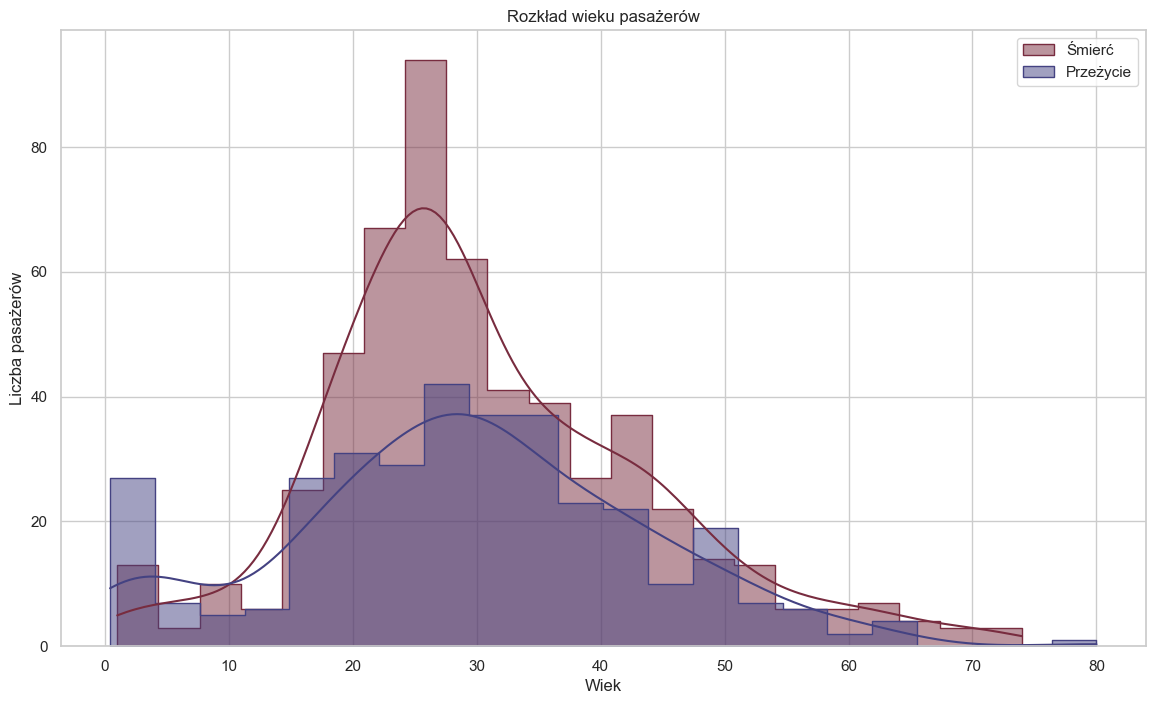

In [28]:
fig, axes = plt.subplots(figsize=(14,8))
axes.set_ylabel('Liczba pasażerów')
axes.set_xlabel('Wiek')
axes.set_title('Rozkład wieku pasażerów')
sns.histplot(Titanic[Titanic['Survived']==0]['Age'],kde=True, bins=22, element='step', label='Śmierć')
sns.histplot(Titanic[Titanic['Survived']==1]['Age'],kde=True, bins=22, element='step', label='Przeżycie')
axes.legend()

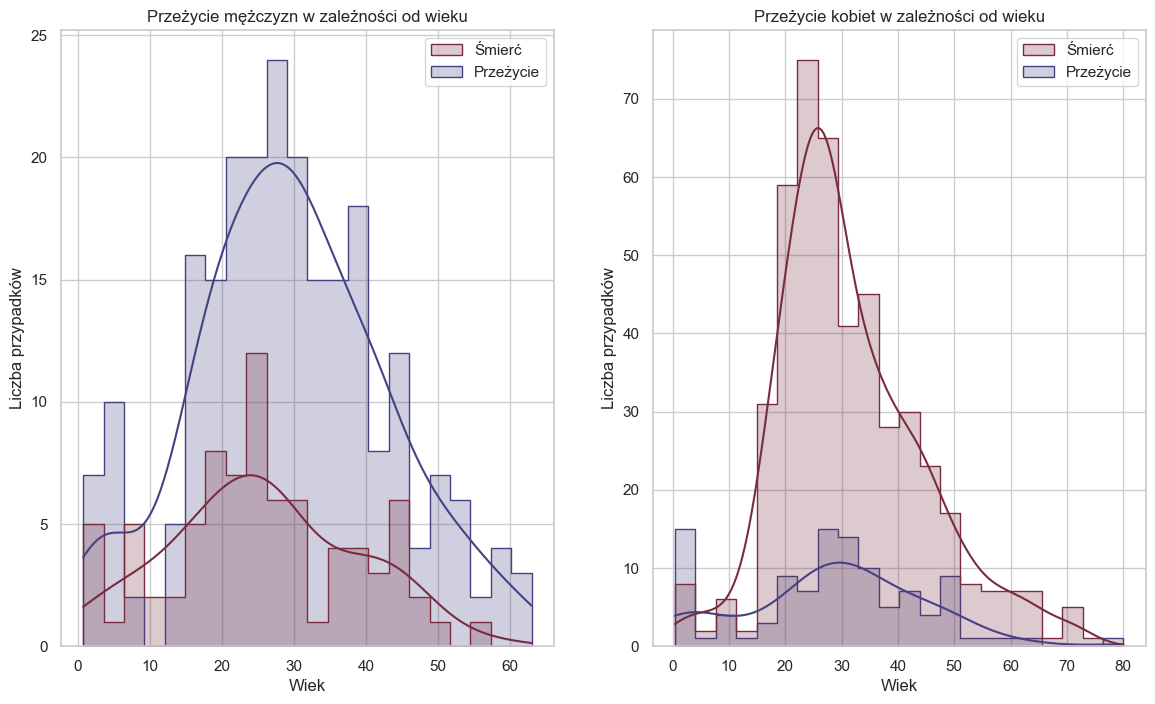

In [29]:
# dwa wykresy
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
# Mężczyźni
sns.histplot(Titanic[Titanic['Sex_Enc']==0], x='Age', hue='Survived', element='step', common_norm=False, ax=ax1, bins=22, kde=True)
ax1.set_xlabel('Wiek')
ax1.set_ylabel('Liczba przypadków')
ax1.set_title('Przeżycie mężczyzn w zależności od wieku')
legend = ax1.get_legend()
handles = legend.legend_handles
ax1.legend(handles, ['Śmierć', 'Przeżycie'])
# Kobiety
sns.histplot(Titanic[Titanic['Sex_Enc']==1], x='Age', hue='Survived', element='step', common_norm=False, ax=ax2, bins=22, kde=True)
ax2.set_xlabel('Wiek')
ax2.set_ylabel('Liczba przypadków')
ax2.set_title('Przeżycie kobiet w zależności od wieku')
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Śmierć', 'Przeżycie'])

C:\Users\domin\AppData\Local\Temp\ipykernel_214024\438540902.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mężczyzni', 'Kobiety'])


Text(0, 0.5, 'Wiek')

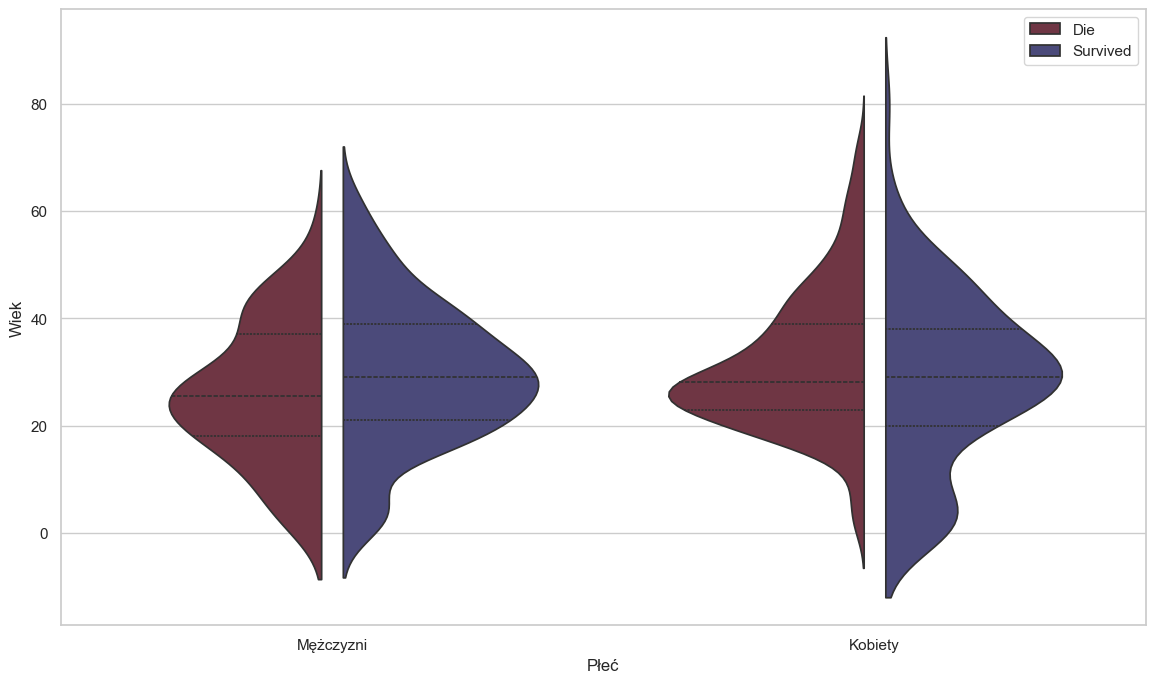

In [30]:
fig, ax = plt.subplots(figsize=(14,8))
sns.violinplot(data=Titanic, x="Sex_Enc", y="Age", hue="Survived", split=True, gap=.1, inner="quart")
legend = ax.get_legend()
handles = legend.legend_handles
ax.legend(handles, ['Die', 'Survived'])
ax.set_xticklabels(['Mężczyzni', 'Kobiety'])
ax.set_xlabel('Płeć')
ax.set_ylabel('Wiek')

Pamiętajmy, że wartość naosi odciętych dla violonplota nie wskazuje częstotoliwości występowania danego zdarzenia. W ziązku z czym kluczowa analiza powinna opierać się głownie na porównaniu krzywej w maksimum. 


### Fare/Calss

<Axes: xlabel='Pclass', ylabel='Fare'>

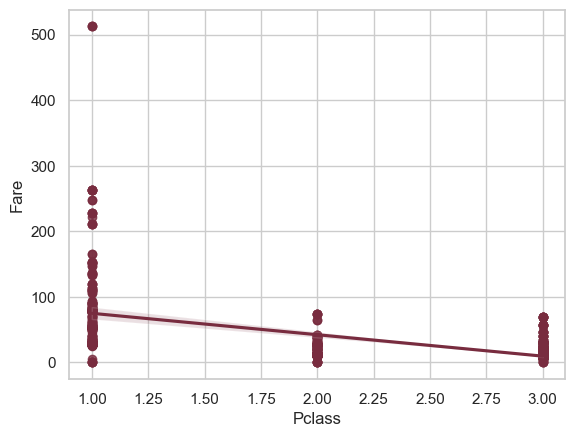

In [31]:
sns.regplot(data=Titanic, x="Pclass", y="Fare")

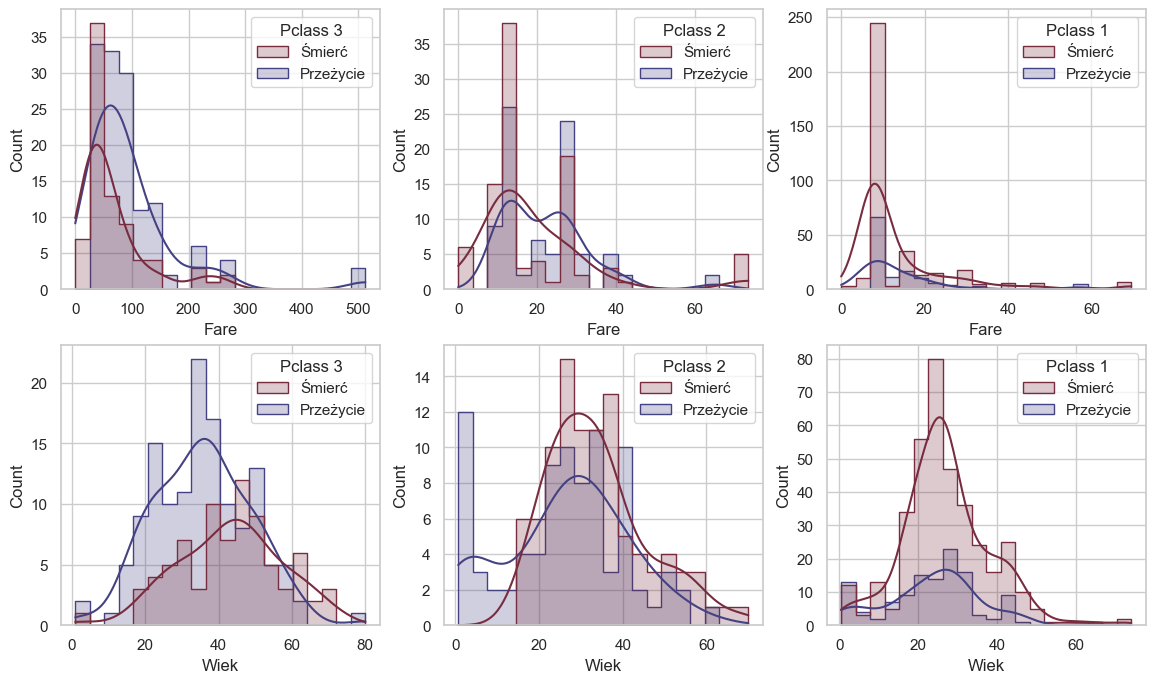

In [32]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
plt.subplots_adjust(hspace=0.2)
# Create histograms for fares (loop over first row)
for i in range(3):
    sns.histplot(Titanic[Titanic['Pclass']==(i+1)], x='Fare', hue='Survived', element='step', common_norm=False, ax=axes[0, i], bins=20, kde=True)
    legend = axes[0,i].get_legend()
    handles = legend.legend_handles
    axes[0, i].legend(handles, ['Śmierć', 'Przeżycie'], title = f'Pclass {3-i}')
# Create histograms for age (loop over second row)
for i in range(3):
    sns.histplot(Titanic[Titanic['Pclass']==(i+1)], x='Age', hue='Survived', element='step', common_norm=False, ax=axes[1, i], bins=20, kde=True)
    axes[1, i].set_xlabel('Wiek')
    legend = axes[1,i].get_legend()
    handles = legend.legend_handles
    axes[1, i].legend(handles, ['Śmierć', 'Przeżycie'], title = f'Pclass {3-i}')

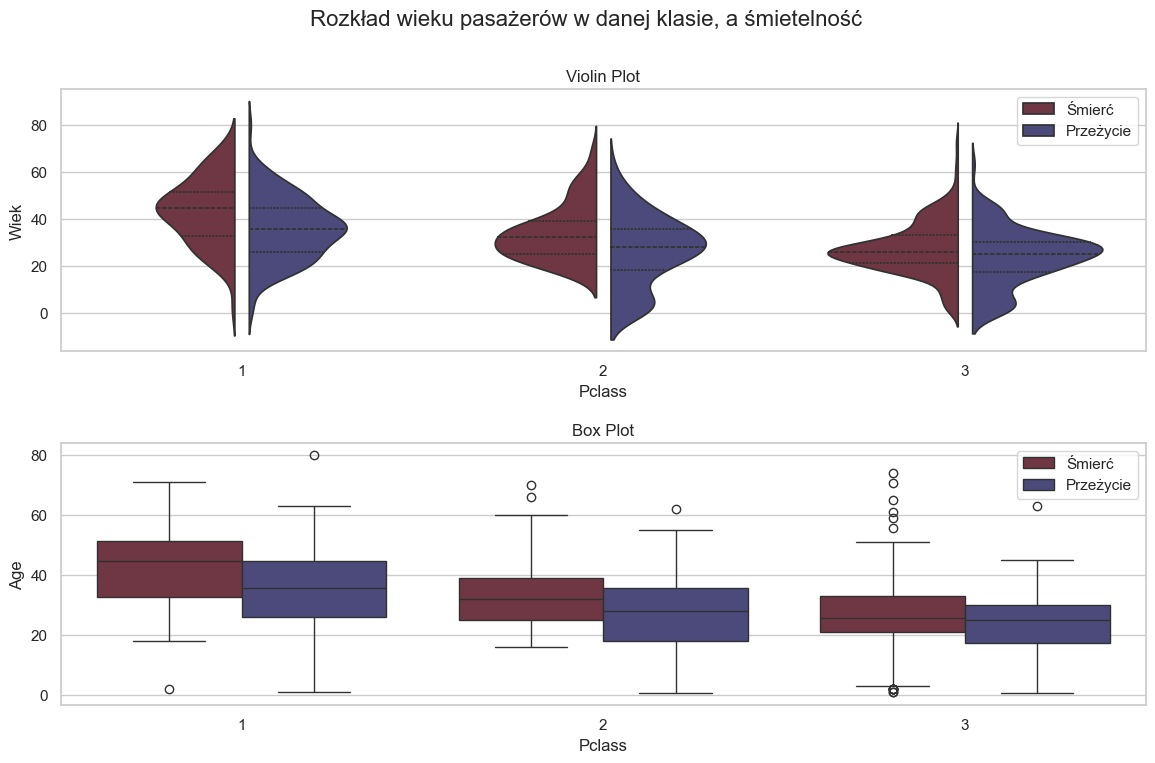

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 8))
fig.suptitle('Rozkład wieku pasażerów w danej klasie, a śmietelność', fontsize=16)
plt.subplots_adjust(hspace=0.35)
sns.violinplot(ax=ax1, data=Titanic, x="Pclass", y="Age", hue="Survived", split=True, gap=.1, inner="quart")
ax1.set_title('Violin Plot')
ax1.set_ylabel('Wiek')
legend = ax1.get_legend()
handles = legend.legend_handles
ax1.legend(handles, ['Śmierć', 'Przeżycie'])

# Box plot on the second subplot (axes[1])
sns.boxplot(ax=ax2, data=Titanic, x="Pclass", y="Age", hue="Survived")
ax2.set_title('Box Plot')
ax1.set_ylabel('Wiek')
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Śmierć', 'Przeżycie'])


### Rodzina

C:\Users\domin\AppData\Local\Temp\ipykernel_214024\1834844578.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=Titanic,   x='FamilySize', y='Survived', palette="icefire", ax=ax1)
C:\Users\domin\AppData\Local\Temp\ipykernel_214024\1834844578.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels([list(title_mapping.keys())[i] for i in title_mapping.values()])


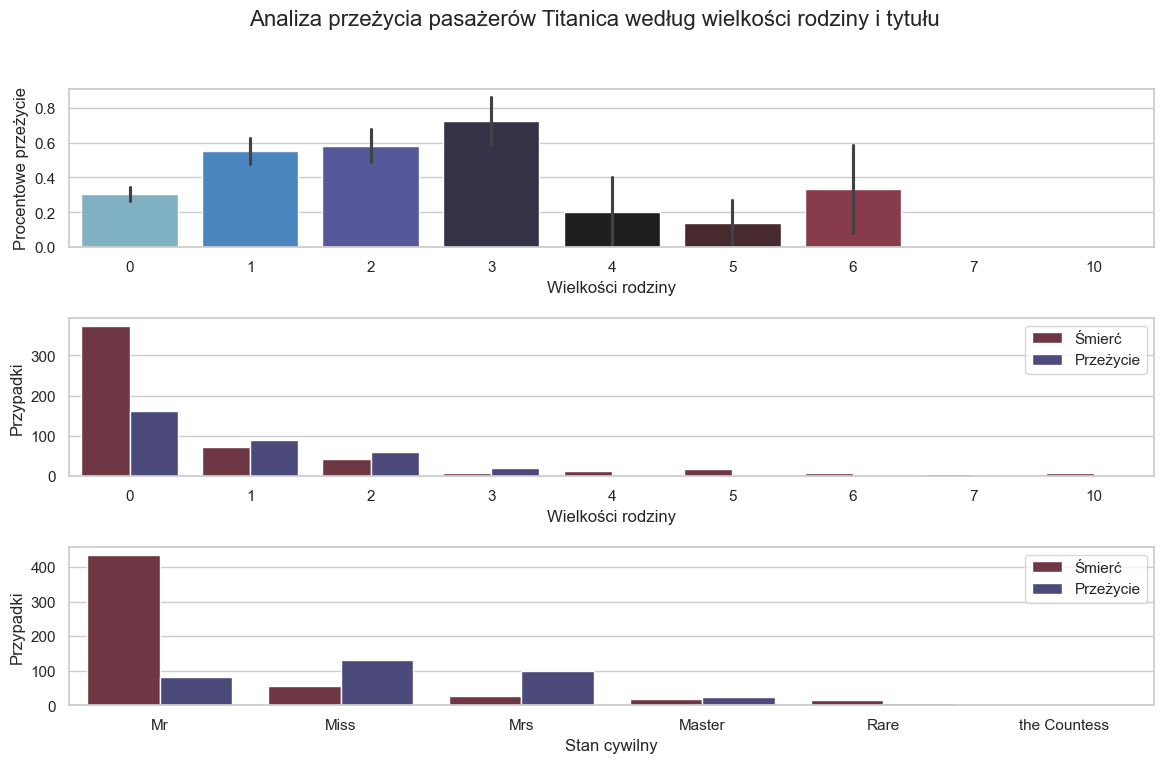

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(14, 8))
plt.subplots_adjust(hspace=0.45)
fig.suptitle('Analiza przeżycia pasażerów Titanica według wielkości rodziny i tytułu', fontsize=16)
ax1.set_xlabel('Wielkości rodziny')
ax1.set_ylabel('Procentowe przeżycie')
sns.barplot(data=Titanic,   x='FamilySize', y='Survived', palette="icefire", ax=ax1)

sns.countplot(data=Titanic, x='FamilySize', hue='Survived',  ax=ax2)
ax2.set_ylabel('Przypadki')
ax2.set_xlabel('Wielkości rodziny')
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Śmierć', 'Przeżycie'])

title_mapping = {
    "Mr": 0,
    "Miss": 1,
    "Mrs": 2,
    "Master": 3,
    "Rare": 4,
    "the Countess": 5
}

sns.countplot(data=Titanic, x='Title_Enc', hue='Survived',  ax=ax3)
ax3.set_ylabel('Przypadki')
ax3.set_xlabel('Stan cywilny')
ax3.set_xticklabels([list(title_mapping.keys())[i] for i in title_mapping.values()])
legend = ax3.get_legend()
handles = legend.legend_handles
ax3.legend(handles, ['Śmierć', 'Przeżycie'])


### Zaokrętowanie  

C:\Users\domin\AppData\Local\Temp\ipykernel_214024\1206179829.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([list(title_mapping.keys())[i] for i in title_mapping.values()])
C:\Users\domin\AppData\Local\Temp\ipykernel_214024\1206179829.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([list(title_mapping.keys())[i] for i in title_mapping.values()])


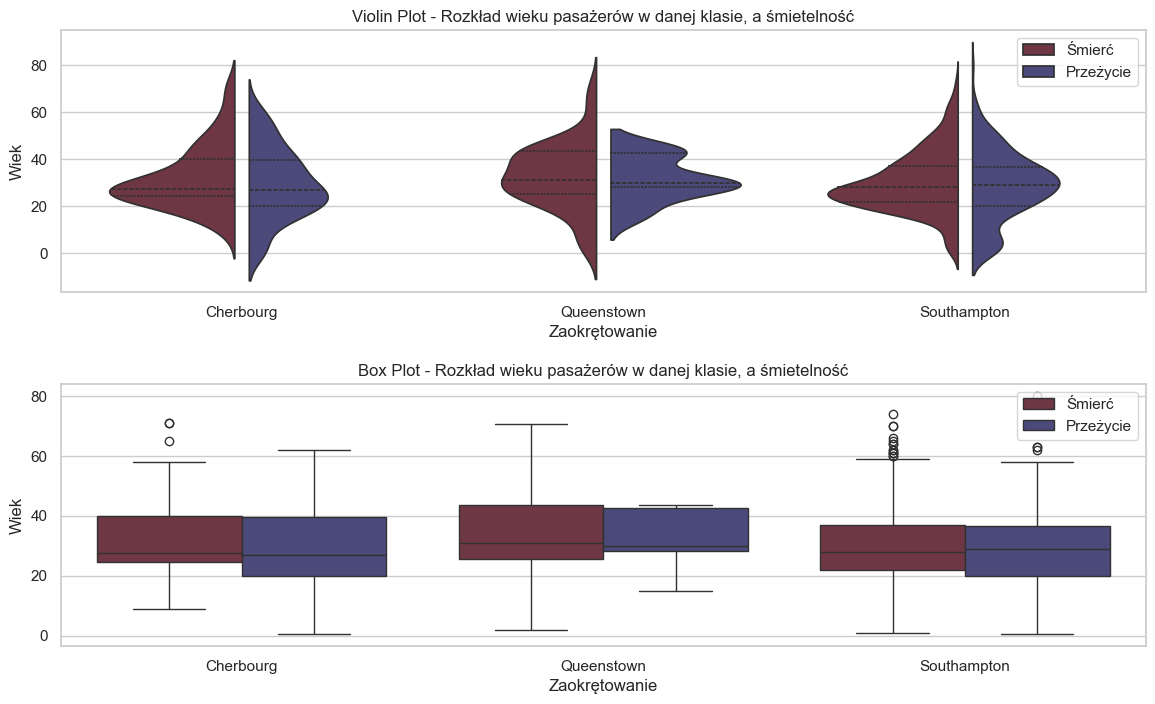

In [35]:
title_mapping = {
    "Cherbourg": 0,
    "Queenstown": 1,
    "Southampton": 2,
}

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 8))
plt.subplots_adjust(hspace=0.35)
sns.violinplot(ax=ax1, data=Titanic, x="Embarked_Enc", y="Age", hue="Survived", split=True, gap=.1, inner="quart")
ax1.set_title('Violin Plot - Rozkład wieku pasażerów w danej klasie, a śmietelność')
ax1.set_ylabel('Wiek')
ax1.set_xlabel('Zaokrętowanie')
ax1.set_xticklabels([list(title_mapping.keys())[i] for i in title_mapping.values()])
legend = ax1.get_legend()
handles = legend.legend_handles
ax1.legend(handles, ['Śmierć', 'Przeżycie'])

# Box plot on the second subplot (axes[1])
sns.boxplot(ax=ax2, data=Titanic, x="Embarked_Enc", y="Age", hue="Survived")
ax2.set_title('Box Plot - Rozkład wieku pasażerów w danej klasie, a śmietelność')
ax2.set_ylabel('Wiek')
ax2.set_xlabel('Zaokrętowanie')
ax2.set_xticklabels([list(title_mapping.keys())[i] for i in title_mapping.values()])
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Śmierć', 'Przeżycie'])

## Modele predykcyjne

In [36]:
#Biblioteki
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics         import make_scorer, f1_score, accuracy_score

from sklearn.neural_network  import MLPClassifier

from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import HistGradientBoostingClassifier

from sklearn.naive_bayes     import GaussianNB

from sklearn.svm             import SVC

from sklearn.neighbors       import KNeighborsClassifier




In [37]:
#Baza danych do nauki
X = Titanic.drop('Survived',axis=1)
y = Titanic['Survived']
y_test = test

In [38]:
#Modele które zostaną wykorzystane
classifiers = [['Random Forest',RandomForestClassifier()],
               ['AdaBoost',AdaBoostClassifier()],
               ['Gradient Boosting',GradientBoostingClassifier()],
               ['Support Vector Machine', SVC()], 
               ['HGBC',HistGradientBoostingClassifier()], 
               ['Naive Bayes',GaussianNB()]
              ]

In [39]:
## Wstępna ocena wydajności modeli z domyślnymi parametrami
for metric in ['accuracy','f1']:
    SKfold = StratifiedKFold(n_splits=6)
    score_mean = []
    std = []
    
    for model in classifiers:
        clf = model[1]
        cv_result = cross_val_score(clf,X,y, cv = SKfold, scoring = metric)
        cv_result = cv_result
        score_mean.append(cv_result.mean())
        std.append(cv_result.std())
        
    models_evaluation = pd.DataFrame({metric: score_mean}, index=[i[0] for i in classifiers])
    print(models_evaluation.sort_values(metric, ascending=False))
    print('*'*32)

                        accuracy
Gradient Boosting       0.827159
HGBC                    0.821543
Random Forest           0.811468
AdaBoost                0.811446
Naive Bayes             0.790155
Support Vector Machine  0.683559
********************************
                              f1
Gradient Boosting       0.759721
HGBC                    0.754738
AdaBoost                0.752181
Random Forest           0.747439
Naive Bayes             0.734422
Support Vector Machine  0.421462
********************************


### Fine tuning dla głownej bazy danych

In [40]:
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Define parameter grids for each classifier
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 125, 150, 175, 200, 225, 250, 300],
        'max_depth': [3, 4, 5, 6, 7, 8, 9]
    },
    'AdaBoost': {
        'n_estimators': [140, 160, 175, 195, 205, 225, 245],
        'learning_rate': [0.75, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [75, 100, 125, 150, 175, 200, 225, 250],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
    },
    'Support Vector Machine': {
        'C': [0.02, 0.03, 0.04, 0.05, 0.06, 0.075, 0.095, 0.105, 0.125],
        'kernel': ['linear', 'rbf']
    },
    'MLPC': {
        'max_iter': [8000],
        'solver' : ['adam'],
        'learning_rate_init' : [0.0175, 0.02, 0.0225, 0.025, 0.03],
        'alpha':                [0.0001, 0.00015, 0.0002, 0.00025],
        'hidden_layer_sizes':  [(12,12), (8,8), (6,6), (3,3,3), (7,7,7) ],
        'activation': ['relu', 'tanh']
        
    },
    'HGBC': {
        'learning_rate': [0.0025, 0.05, 0.0075, 0.1, 0.25, 0.5]
    }
}

classifiers = [
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('MLPC', MLPClassifier()),
    ('HGBC', HistGradientBoostingClassifier())
    
]


# Perform GridSearchCV for each classifier with accuracy evaluation
for name, clf in classifiers:
    # Create a scoring function (using accuracy_score)
    param_grid = param_grids[name]
    # 1. Refit with a specific metric (e.g., 'accuracy')
    scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=SKfold, scoring=scoring, refit='accuracy')

    # 2. No refitting (evaluate across all metrics)
    # scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
    # grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=5, scoring=scoring, refit=False)
    #grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring=scoring)  # Adjust cv as needed
    
    grid_search.fit(X, y)

    # Print the best model's accuracy and parameters
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    print(f"\n{name} Model:")
    print(f"Best Accuracy on Training Data: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")




Random Forest Model:
Best Accuracy on Training Data: 0.8339
Best Parameters: {'max_depth': 7, 'n_estimators': 175}

AdaBoost Model:
Best Accuracy on Training Data: 0.8227
Best Parameters: {'learning_rate': 0.85, 'n_estimators': 205}

Gradient Boosting Model:
Best Accuracy on Training Data: 0.8373
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}

Support Vector Machine Model:
Best Accuracy on Training Data: 0.8137
Best Parameters: {'C': 0.02, 'kernel': 'linear'}

MLPC Model:
Best Accuracy on Training Data: 0.8227
Best Parameters: {'activation': 'relu', 'alpha': 0.00025, 'hidden_layer_sizes': (7, 7, 7), 'learning_rate_init': 0.025, 'max_iter': 8000, 'solver': 'adam'}

HGBC Model:
Best Accuracy on Training Data: 0.8384
Best Parameters: {'learning_rate': 0.05}


## Stosowanie modeli

In [41]:
classifier_dict = {
    'Random Forest': RandomForestClassifier(n_estimators=150, max_depth = 7),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1 ),
    'Support Vector Machine': SVC(C=0.038,kernel='linear', probability=True),
    'MLPC': MLPClassifier(max_iter=8000,solver='adam', learning_rate_init=0.0225, alpha=0.000225, hidden_layer_sizes=(12,12), activation='relu'),
    'HGBC': HistGradientBoostingClassifier(learning_rate=0.05)
}

for name, model in classifier_dict.items():
    model.fit(X, y)

X_test = test
y_test = []
testt = pd.read_csv("test.csv")


# Przewiduj prawdopodobieństwo przeżycia dla każdego modelu
submission_df = pd.DataFrame({"PassengerId": testt['PassengerId']})
for i in range(len(submission_df)):
    for name, model in classifier_dict.items():
        y_pred = model.predict_proba(X_test.iloc[[i]])[0, 1]
        submission_df.loc[i, name] = y_pred

# Wybierz ostateczną predykcję (średnia)
final_predictions = []
for i in range(len(submission_df)):
    proba_cols = [col for col in submission_df.columns if col.startswith(tuple(classifier_dict.keys()))]
    avg_proba = sum(submission_df.iloc[i][proba_cols]) / len(proba_cols)
    final_predictions.append(avg_proba)

# Optional: Thresholding for 0 or 1 predictions
#threshold = 0.5
#final_predictions = [1 if p > threshold else 0 for p in final_predictions]

submission_df['Survived'] = final_predictions
submission_df.to_csv('submission.csv', index=False)


In [42]:
# from sklearn.preprocessing import PolynomialFeatures
# # Wybierz parametry
# features = ['Sex_Enc', 'FamilySize']

# # Utwórz obiekt PolynomialFeatures
# poly = PolynomialFeatures(degree=2, interaction_only=True)

# # Przekształć dane
# X_fare_sex = poly.fit_transform(Titanic[features])

# # Dodaj kolumny z nowymi cechami do DataFrame
# Titanic['Fare_Sex_Poly2'] = X_fare_sex[:, 1]
# Titanic['Fare_Sex_Poly3'] = X_fare_sex[:, 2]

# # Wyświetl pierwsze 5 wierszy DataFrame
# fig, ax = plt.subplots(figsize=(9, 9))
# sns.heatmap(Titanic.astype(float).corr(),linewidths=0.1,vmax=1.0, 
#             square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
# ax.set_title('Pearson Correlation of Features', y=1.05, size=15)
# Titanic.head(20)